# The Timeseries Quantum Autoencoder
*TS QAE in Qiskit with angle encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - April 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder, 
    however, for comparison a classical neural net-based AE is also built and tested here.
Previously: 
- Time series data was converted to a differenced series of pure and noisy sliding windows ("data" notebook)
- Windows are then encoded for quantum processing (offset from H position) ("data" notebook)

Methods:
- Differenced windows for pure and noisy data is loaded for training and validation
- A simple neural net-based AE is then built and tested

Sources: 
1. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.
2. Ali Shannon, "techshot25/Autoencoders", accessed March 12, 2024, https://github.com/techshot25/Autoencoders.
3. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
4. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
sys.path

['/home/jacob/miniconda3/envs/qiskit_qae/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit_qae/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit_qae/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit_qae/lib/python3.10/site-packages',
 '.',
 '..',
 '../..',
 '../../..']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
import copy
import os.path as path

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
from utils.Circuits import *
from utils.Angles import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

## Load dataset hyper-parameters

In [4]:
### Constants
LOG_NAME = 'beer_xtest'
CASE_NAME = '2step_torch'
DATA_NAME = 'beer_2step'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
SCORES_PATH = f'{LOG_NAME}/scores'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, SCORES_PATH, FIGURES_PATH)

('beer_xtest',
 '2step_torch',
 'beer_2step',
 'beer_xtest/data',
 'beer_xtest/training',
 'beer_xtest/params',
 'beer_xtest/analysis',
 'beer_xtest/scores',
 'beer_xtest/figures')

In [5]:
### Load repository info
data_info_path = f'{DATA_PATH}/beer_2step_n200_w8_ws2_z0.03_zr1_info.json'
data_info = read_json_file(data_info_path)
data_info

{'case_name': 'beer_2step',
 'major_version': 4,
 'minor_version': 0,
 'samples': 200,
 'split': 0.75,
 'wind_size': 8,
 'wind_step': 2,
 'horizon': 1,
 'scale': 1,
 'pan': 0,
 'noise': 0.03,
 'noise_reps': 1}

In [6]:
### Load all data hyper-parameters

# Software version
major_version = data_info['major_version']
minor_version = data_info['minor_version']

# Data settings
samples = data_info['samples']
split = data_info['split']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['horizon']
scale = data_info['scale']
pan = data_info['pan']

# Noise level
noise = data_info['noise']
noise_reps = data_info['noise_reps']

In [7]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
DATA_PREF = f'{DATA_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}'
DATA_PREF

'beer_2step_n200_w8_ws2_z0.03_zr1'

### Load previously saved TSs

In [8]:
### Identify all dataset files

y_train_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_org.arr'
y_valid_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_org.arr'
y_train_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_org.arr'
y_valid_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_org.arr'

y_train_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_ts.arr'
y_train_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_ts.arr'
y_valid_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_ts.arr'

y_train_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_enc.arr'
y_valid_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_enc.arr'
y_train_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_enc.arr'
y_valid_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_enc.arr'

info_file_path = f'{DATA_PATH}/{DATA_PREF}_info.json'
info_file_path

'beer_xtest/data/beer_2step_n200_w8_ws2_z0.03_zr1_info.json'

In [9]:
### Load only the relevant TSs

y_train_enc = read_ts_file(y_train_enc_fpath)
y_valid_enc = read_ts_file(y_valid_enc_fpath)

y_train_noisy_enc = read_ts_file(y_train_noisy_enc_fpath).reshape(noise_reps, y_train_enc.shape[0], y_train_enc.shape[1])
y_valid_noisy_enc = read_ts_file(y_valid_noisy_enc_fpath).reshape(noise_reps, y_valid_enc.shape[0], y_valid_enc.shape[1])

### Plot loaded TSs



TS noise = 3.0%, calculated noise in differenced TS = 2.7%, total noise = 63.0641, over the points = 1168



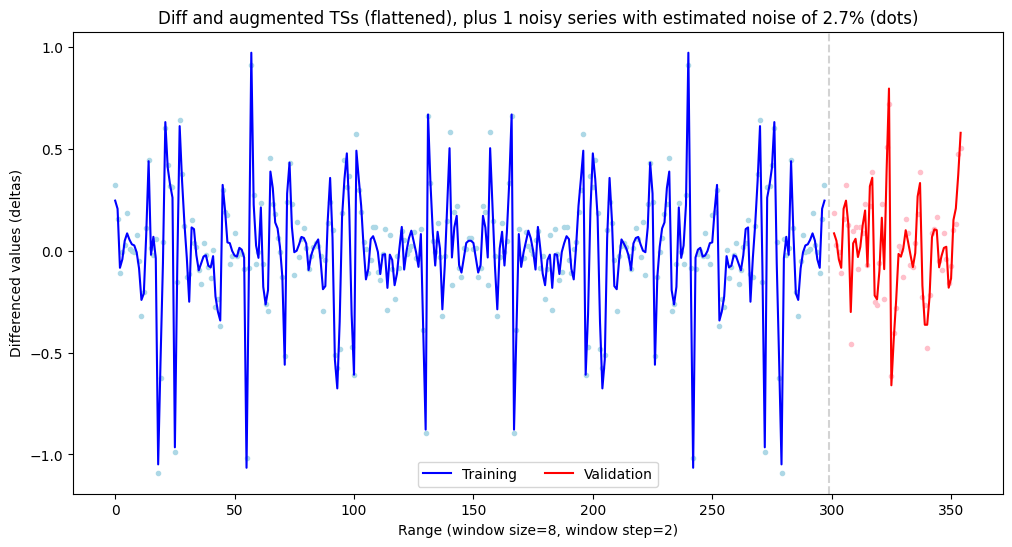

In [10]:
qae_diffaug_plot(y_train_enc, y_valid_enc, y_train_noisy_enc, y_valid_noisy_enc, wind_step, noise, noise_reps,
                 xlabel=f'Range (window size={wind_size}, window step={wind_step})',
                 ylabel='Differenced values (deltas)')

## Building and training a Quantum Autoencoder

In [11]:
### Libraries used in QAE development

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
from torch import nn, tensor, optim
from torch.utils.data import DataLoader, Dataset
# from torchviz import make_dot
from sklearn.preprocessing import MinMaxScaler

### Simulator device

In [12]:
### Find what devices are available
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cpu'

### QAE training parameters

In [13]:
reps=0 # Needs exploring
ent='none' # N/A for torch
rot_block='none'
num_qubits = wind_size
num_trash = 1
num_latent = num_qubits-num_trash
added_width = 0
shuffle_interv = 0
log_interv = 100
cost_type = 'L1' # torch
cost_yscale = 'linear' # linear, log
epochs = 30000
shots=0
seed=2024

In [14]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
TRAIN_PREF = f'{CASE_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}_reps{reps}_aw{added_width}_{ent}_lat{num_latent}'
TRAIN_PREF

'2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7'

In [15]:
### Training info files 
train_info_default_fpath = f'{TRAIN_PATH}/info.json'
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_init.json'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist{epochs}.json'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}_params.json'
hist_chart_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist.eps'
train_info_fpath

'beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_info.json'

In [16]:
### Save training parameters
### Save info details
train_info = \
    {'case_name':CASE_NAME, 
     'major_version':major_version, 
     'minor_version':minor_version,
     'reps':reps,
     'ent':ent, 
     'rot_block':rot_block,
     'num_qubits':num_qubits,
     'num_trash':num_trash, 
     'num_latent':num_latent, 
     'added_width':added_width,
     'cost_type':cost_type, 
     'cost_yscale':cost_yscale,
     'shuffle_interv':shuffle_interv,
     'log_interv':log_interv,
     'epochs':epochs,
     'shots':shots,
     'seed':seed}

### Saving the info file
write_json_file(train_info_fpath, train_info)
write_json_file(train_info_default_fpath, train_info)
    
print(f'\nSaved time series info in file "{train_info_fpath}":\n')
for k in train_info.keys():
    print(f'\tinfo[{k}] = {train_info[k]}')
print()


Saved time series info in file "beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_info.json":

	info[case_name] = 2step_torch
	info[major_version] = 4
	info[minor_version] = 0
	info[reps] = 0
	info[ent] = none
	info[rot_block] = none
	info[num_qubits] = 8
	info[num_trash] = 1
	info[num_latent] = 7
	info[added_width] = 0
	info[cost_type] = L1
	info[cost_yscale] = linear
	info[shuffle_interv] = 0
	info[log_interv] = 100
	info[epochs] = 30000
	info[shots] = 0
	info[seed] = 2024



## Definine, train and test a model
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

### Pytorch utilities 

In [17]:
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

### Prepare data for torch use

In [18]:
y_train_tens = torch.from_numpy(y_train_enc).to(device)
y_valid_tens = torch.from_numpy(y_valid_enc).to(device)
y_train_noisy_tens = torch.from_numpy(y_train_noisy_enc).to(device)
y_valid_noisy_tens = torch.from_numpy(y_valid_noisy_enc).to(device)

### Functions to create and train a model

In [19]:
### Simple autoencoder
class Autoencoder(nn.Module):

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

### Trains the classical AE model
def train(model, error, optimizer, epochs, x, log_interv=100, prompt_fract=0.1):
    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)


### Trains the AE with noisy input and clean output
def train_with_noise(model, error, optimizer, epochs, x_noisy, y_pure, log_interv=100, prompt_fract=0.1):
    history = []
    min_epoch = 0
    min_loss = 1000
    opt_params = {}
    hist_params = []
    running_loss = 0
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(x_noisy)
        loss = error(output, y_pure)
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.item()
        if curr_loss < min_loss: 
            min_loss = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if epoch % log_interv == 0:
            history.append(curr_loss)
            hist_params.append(copy.deepcopy(model.state_dict()))

        if epoch % int(prompt_fract*epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
            
        running_loss += curr_loss

    return history, opt_params, hist_params, (min_epoch, min_loss)

In [20]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
cae = Autoencoder(in_shape=wind_size, enc_shape=num_latent).double().to(device)

### Loss and optimiser

# error = nn.MSELoss()
error = nn.L1Loss()

# optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
optimizer = optim.Adam(cae.parameters())

### Show 
cae.eval()

Autoencoder(
  (encode): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=7, bias=True)
  )
  (decode): Sequential(
    (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=7, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=8, bias=True)
  )
)

In [21]:
### Train the model
start = time.time()

# cuda Fit (58 samples, 5+3=8 window, 19479 params, 30000 epochs): 0.01207 min cost @ iter# 28510, 19.85 sec
# history, opt_params, opt_point = train(cae, error, optimizer, epochs, y_train_tens, log_interv=log_interv, prompt_fract=0.1)

# cuda Fit (58 samples, 5+3=8 window, 19479 params, 30000 epochs): 0.01196 min cost @ iter# 27561, 19.62 sec
sel_noisy_rec = 0
history, opt_params, hist_params, opt_point = \
    train_with_noise(cae, error, optimizer, epochs, y_train_noisy_tens[sel_noisy_rec], y_train_tens, log_interv=log_interv, prompt_fract=0.1)

elapsed = time.time() - start

# Print run statistics
print(f'\n'+
      f'{device} Fit ('+
      f'{y_train_tens.shape[0]} samples, '+
      f'{num_latent}+{num_trash}={wind_size} window, '+
      f'{count_params(cae)} params, '+
      f'{epochs} epochs): '+
      f'{round(opt_point[1], 5)} min cost @ iter# {opt_point[0]}, '+
      f'{elapsed:0.2f} sec'+
      f'\n'
     )

epoch 0 	 Loss: 0.2466
epoch 3000 	 Loss: 0.06454
epoch 6000 	 Loss: 0.0591
epoch 9000 	 Loss: 0.0535
epoch 12000 	 Loss: 0.05376
epoch 15000 	 Loss: 0.0525
epoch 18000 	 Loss: 0.05415
epoch 21000 	 Loss: 0.05052
epoch 24000 	 Loss: 0.05061
epoch 27000 	 Loss: 0.05471

cpu Fit (146 samples, 7+1=8 window, 19741 params, 30000 epochs): 0.0445 min cost @ iter# 23544, 55.50 sec



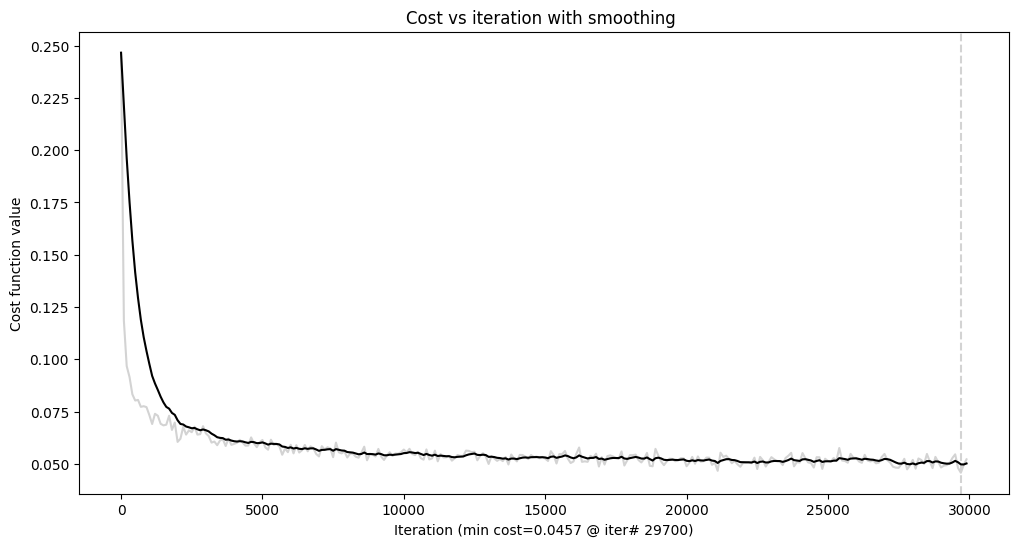

In [24]:
cost_plot(history, rcParams=(12, 6), backplot=True, back_color='lightgray', smooth_weight=0.8, log_interv=log_interv, 
          save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_hist{epochs}.eps')

In [25]:
# Models structures

print(f'Encoder characteristics: \n\n'+
      f'\ttraining windows={len(y_train_enc)}\n'+
      f'\tvalidation windows={len(y_valid_enc)}\n'+
      f'\tinputs={wind_size}\n'+
      f'\tkeep_encoder=N/A\n'+
      f'\tweights={count_params(cae)}\n'+
      f'\ttrash layer={num_trash}\n'+
      f'\tlatent layer={num_latent}\n'+
      f'\treps={reps}\n'+
      f'\tent=N/A\n'+
      f'\tnoise={noise}\n'+
      f'\tnoise repeats={noise_reps}\n'+
      f'\n'+
      f'\tshuffle interv={shuffle_interv}\n'+
      f'\tlog interv={log_interv}\n'+
      f'\tcost type={cost_type}\n'+
      f'\tcost yscale={cost_yscale}\n'+
      f'\tsamples={y_train_enc.shape[0]}\n'+
      f'\tdevice={device}\n'+
      f'\tepochs={epochs}\n'+
      f'\tshots={shots}\n'+
      ''
     )


Encoder characteristics: 

	training windows=146
	validation windows=24
	inputs=8
	keep_encoder=N/A
	weights=19741
	trash layer=1
	latent layer=7
	reps=0
	ent=N/A
	noise=0.03
	noise repeats=1

	shuffle interv=0
	log interv=100
	cost type=L1
	cost yscale=linear
	samples=146
	device=cpu
	epochs=30000
	shots=0



### Saving the loss history, selected parameters and the optimum params
Optimum parameters are for training - not validation)

In [26]:
print(f'Files to be saved (when True)\n')
print(f'Optimisation init point: {init_fpath}')
print(f'History of Cost:         {history_fpath}')
print(f'Optimisation parameters: {params_fpath}')
print()

Files to be saved (when True)

Optimisation init point: beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_init.json
History of Cost:         beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_hist30000.json
Optimisation parameters: beer_xtest/params/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_params.json



**Note:** *the torch model parameters can be loaded into the model with: 
model.load_state_dict(torch.load(PATH))*

In [27]:
### Save the initial point, also save the history file
to_be_saved_starting_point = True

print()
if to_be_saved_starting_point:
    ## Saving the initialisation point
    torch.save(opt_params, f'{init_fpath}')
    print(f'Saved optimum parameters as the future starting point in:\n\t{init_fpath}')

    ### Saving the history file
    write_json_file(f'{history_fpath}', history)
    print(f'Saved optimisation history in:\n\t{history_fpath}')

    ## Saving all optimisation params
    params_parent_fpath = path.abspath(os.path.join(params_fpath, os.pardir))
    param_info = \
        {'case_name':CASE_NAME, 
         'major_version':major_version, 
         'minor_version':minor_version,
         'log_interv':log_interv,
         'log_number':len(hist_params)}
    write_json_file(f'{params_parent_fpath}/info.json', param_info) # Last
    write_json_file(f'{params_fpath[:-5]}_info{params_fpath[-5:]}', param_info)
    for next_params_no in range(len(hist_params)):
        next_param_pname = f'{params_fpath[:-5]}_{next_params_no:04d}{params_fpath[-5:]}'
        torch.save(hist_params[next_params_no], f'{next_param_pname}')
    print(f'Saved all optimisation parameters in files:\n\t{params_fpath[:-5]}_xxxx{params_fpath[-5:]}')

else:
    print(f'Parameters and history not saved') 
print()


Saved optimum parameters as the future starting point in:
	beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_init.json
Saved optimisation history in:
	beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_hist30000.json
Saved all optimisation parameters in files:
	beer_xtest/params/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_params_xxxx.json



## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

# Software in use

In [28]:
!conda env list

# conda environments:
#
base                     /home/jacob/miniconda3
qiskit                   /home/jacob/miniconda3/envs/qiskit
qiskit1.bak              /home/jacob/miniconda3/envs/qiskit1.bak
qiskit100                /home/jacob/miniconda3/envs/qiskit100
qiskit_qae            *  /home/jacob/miniconda3/envs/qiskit_qae
tf2                      /home/jacob/miniconda3/envs/tf2



In [29]:
!pip list | grep -E 'qiskit|torch'

qiskit                    0.46.0
qiskit-aer                0.13.3
qiskit-algorithms         0.2.2
qiskit-machine-learning   0.7.1
qiskit-terra              0.46.0
torch                     2.3.0+cpu
torchaudio                2.3.0+cpu
torchvision               0.18.0+cpu
